# Capstone 2 - Modeling

Question: What is the evolution of the impact of catastrophic events on the commercial aerial traffic in Canada, between 2001 and 2018?

Previous steps:
- In the Data Wrangling step, data was collected from two open source datasets, which were called "disaster" and "airline". Missing values have been managed, time values have been formatted, relevant columns have been preserved while the others have been droped and both datasets were set to correspond to the same timeframe. The airline dataset has futher been fragmented into two, corresponding to airline_total (at the country scale) and airline_local (at the province and territory scale). Here are the remaining cleaned dataset:
    - The disaster dataset contains the information relative to the natural disasters recorded in Canada during the period between 2001 and 2018.
    - The airline_total dataset contains the monthly total aerial movements for Canada for the period between 2001 and 2018.
    - The airline_local dataset contains the monthly aerial movements recorded for each airports of Canada for the period between 2001 and 2018
- In the Exploratory Data Analysis step, specific occurences of each type of disaster events were observed (absolute and yearly, and geographically). In the airline_total dataset, the frequence of total aerial movement by year and by month was verified, while in the airline_local dataset, the frequence of total aerial movement yearly and monthly was observed for each provinces and territories. Datasets were than merged to create disaster_local_monthly (merged_df).
- In the Pre-processing and Training Data Development step, dummy variables were assigned to categorical values ('EVENT_TYPE' and 'prov_ter'). The merged dataframe was further splitted into train and test data (75:25).

Associated notebooks:
- Data Wrangling: https://github.com/LaurenceFB/Capstone2/blob/main/Capstone2_DataWrangling_LForgetBrisson.ipynb
- Exploratory Data Analysis: https://github.com/LaurenceFB/Capstone2/blob/main/Capstone2_EDA_LForgetBrisson.ipynb
- Pre-processing and Training Data Development: https://github.com/LaurenceFB/Capstone2/blob/main/Capstone2_Pre-processingTraining_LForgetBrisson.ipynb


Unsupervised prediction modeling is used in this project to predict the aerial trafic (a continuous variable) through time considering the occurance of environmental disaster events. 

2 modeling methods will be tested on this dataset:
1) Linear regression; and 2) Random Forest.

- A linear regression model allows to simulates the relation between one or multiple independent variables and the target (dependent) variable, in order to assess trends and generate estimation or prevision.

- Random forest perfoms multiple decision trees, each making a prediction (classification or regression), in order to improve accuracy and minimize over-fitting.

In [121]:
# Importing pertinent packages
import numpy as np
import pandas as pd

from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [122]:
# Importing the dataset
df = pd.read_csv('df.csv')
df

,prov_ter,VALUE,year,month,Avalanche,Drought,Earthquake,Flood,Heat Event,Hurricane / Typhoon / Tropical Storm,...,BC,MB,NB,NFL,NS,NWT,ON,QC,SK,YU
0,2.0,49568.0,2001.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,89058.0,2001.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,4.0,19869.0,2001.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
3,7.0,4966.0,2001.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,9.0,7964.0,2001.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2360,11.0,3390.0,2018.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2361,5.0,92554.0,2018.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2362,6.0,40929.0,2018.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2363,3.0,11215.0,2018.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [123]:
# Verification of the columns contained in the dataset.
df.columns

Index(['prov_ter', 'VALUE', 'year', 'month', 'Avalanche', 'Drought',
       'Earthquake', 'Flood', 'Heat Event',
       'Hurricane / Typhoon / Tropical Storm', 'Landslide',
       'Storm - Unspecified / Other', 'Storm Surge',
       'Storms and Severe Thunderstorms', 'Tornado', 'Wildfire',
       'Winter Storm', 'sum_events', 'AB', 'BC', 'MB', 'NB', 'NFL', 'NS',
       'NWT', 'ON', 'QC', 'SK', 'YU'],
      dtype='object')

## 1) Linear regression

### 1.1 Linear model

In [124]:
# Spliting data into training and testing set
X = df.drop('VALUE', axis = 1)
y = df.VALUE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [125]:
# Initialization of the model and fit.
rModel = linear_model.LinearRegression(normalize=True)
rModel.fit(X_train, y_train)

LinearRegression(normalize=True)

In [126]:
# Model prediction.
y_pred = rModel.predict(X_test)

In [127]:
# Evaluation of the model.
print('R2 score:', metrics.r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.9530718569318172
RMSE: 8373.442313630876


Interpretation of evaluation metrics:
- R-squared coefficient (R2 score) measures the rightness of the fit. The value can be averaged to 0.95, indicating that the data are well honored by the model.
- Root Mean Squared Error (RMSE) is an evaluation metrics indicating how spread out the data is around the best fit. In this present case, the RMSE is quite high (8454).

Text(0, 0.5, 'Predicted values')

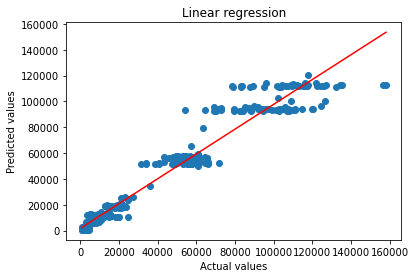

In [128]:
# Scatter plot of the predictions vs the actual result.
plt.scatter(y_test,y_pred)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='r')
plt.title("Linear regression")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")

### 1.2 Ordinary Least Squares (OLS) linear regression.

In [129]:
# Spliting data into training and testing set
X = sm.add_constant(X)
y = df.VALUE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Initialization and fit of the model.
rModel2 = sm.OLS(y_train, X_train).fit()

# Model prediction.
y_pred = rModel2.predict(X_test)

C:\Users\laurence\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [130]:
# Model summary.
rModel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  VALUE   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1368.
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        19:03:16   Log-Likelihood:                -19874.
No. Observations:                1892   AIC:                         3.980e+04
Df Residuals:                    1867   BIC:                         3.994e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
prov_ter                              2585.2720   3035.516      0.852      0.395   -3368.090    8538.634
year                                   -88.4168     39.544     -2.236      0.025    -165.972     -10.861
month                                 1.801e+05   5.62e+04      3.208      0.001       7e+04     2.9e+05
Avalanche                            -1.621e+04   5988.063     -2.708      0.007    -2.8e+04   -4470.770
Drought                               2360.6544   3934.893      0.600      0.549   -5356.596    1.01e+04
Earthquake                            3337.3955   8355.035      0.399      0.690    -1.3e+04    1.97e+04
Flood                                 4058.0025   1669.505      2.431      0.015     783.710    7332.295
Heat Event                            1.208e+04   8361.611      1.444      0.149   -4323.358    2.85e+04
Hurricane / Typhoon / Tropical Storm  1987.9349   4956.798      0.401      0.688   -7733.513    1.17e+04
Landslide                            -7497.5386   5039.293     -1.488      0.137   -1.74e+04    2385.701
Storm - Unspecified / Other            661.0678   2837.118      0.233      0.816   -4903.189    6225.325
Storm Surge                          -8620.3153   8357.393     -1.031      0.302    -2.5e+04    7770.500
Storms and Severe Thunderstorms       3062.6660   1687.123      1.815      0.070    -246.179    6371.511
Tornado                               5819.3511   2680.577      2.171      0.030     562.108    1.11e+04
Wildfire                              8780.2219   1719.803      5.105      0.000    5407.284    1.22e+04
Winter Storm                          -1.08e+04   2674.570     -4.039      0.000    -1.6e+04   -5556.052
sum_events                            -991.1141   1379.188     -0.719      0.472   -3696.026    1713.798
AB                                    4.782e+04   1.73e+04      2.772      0.006     1.4e+04    8.17e+04
BC                                    8.825e+04   2.03e+04      4.348      0.000    4.84e+04    1.28e+05
MB                                    6239.7977   1.12e+04      0.557      0.577   -1.57e+04    2.82e+04
NB                                   -8477.5403   2169.521     -3.908      0.000   -1.27e+04   -4222.600
NFL                                  -1.857e+04   4043.232     -4.594      0.000   -2.65e+04   -1.06e+04
NS                                   -1.588e+04   1152.403    -13.783      0.000   -1.81e+04   -1.36e+04
NWT                                  -2.624e+04   1.01e+04     -2.600      0.009    -4.6e+04   -6445.602
ON                                    9.756e+04   8152.357     11.968      0.000    8.16e+04    1.14e+05
QC                                    3.384e+04   5131.610      6.595      0.000    2.38e+04    4.39e+04
SK                                    

Interpretation of evaluation metrics:
- R2 score can again be averaged to 0.95 for this model. This indicates that 'standard' and OLS linear regression are equivalently predecting data.

Text(0, 0.5, 'Predicted values')

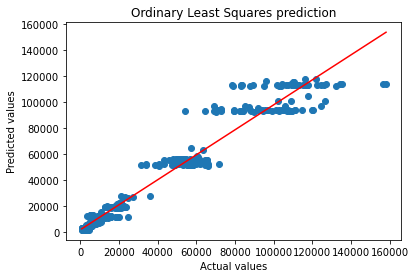

In [131]:
# Scatter plot of the predictions vs the actual result.
plt.scatter(y_test, y_pred)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='r')
plt.title("Ordinary Least Squares prediction")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")

## 2) Random forest regressor

In [132]:
# Spliting data into training and testing set.
X = df.drop('VALUE', axis = 1)
y = df.VALUE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Model initialization, fit and predict.
RFmodel = RandomForestRegressor(random_state=42)

RFmodel.fit(X_train, y_train)

y_pred = RFmodel.predict(X_test)

#### Default Parameters:
- 'bootstrap': True, # Method of selecting samples for training each tree
- 'criterion': 'mse',
- 'max_depth': None, # Maximum number of levels in tree
- 'max_features': 'auto', # Number of features to consider at every split
- 'max_leaf_nodes': None,
- 'min_impurity_decrease': 0.0,
- 'min_impurity_split': None,
- 'min_samples_leaf': 1, # Minimum number of samples required at each leaf node
- 'min_samples_split': 2, # Minimum number of samples required to split a node
- 'min_weight_fraction_leaf': 0.0,
- 'n_estimators': 10, # Number of trees in random forest
- 'n_jobs': 1,
- 'oob_score': False,
- 'random_state': 42,
- 'verbose': 0,
- 'warm_start': False

28


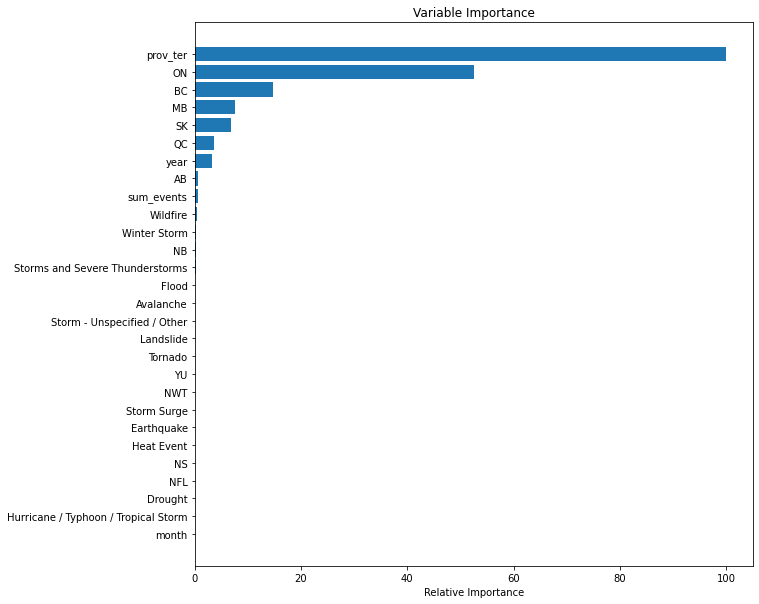

In [133]:
feature_importance = RFmodel.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Text(0, 0.5, 'Predicted values')

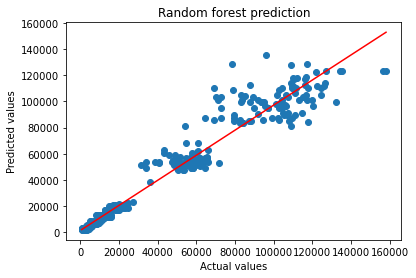

In [134]:
# Scatter plot of the predictions vs the actual result.
plt.scatter(y_test, y_pred)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)), color='r')
plt.title("Random forest prediction")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")

In [135]:
print('R2 score:', metrics.r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.9521684731021068
RMSE: 8453.65403323301


Interpretation of evaluation metrics:
- R2 score can also be averaged to 0.95, indicating that 'standard' and OLS linear regression, as well as the default Random forest are equivalently predecting data.
- There is no improvement in the RMSE value from the other tested model.

## Random forest parameter tuning

### Cross validation

In [136]:
# K-Fold CV
# Preparation of the random grid to search for the best parameters.
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [137]:
# Initiating the random search model with 3 fold cross validation and fit.
search = RandomizedSearchCV(estimator = RFmodel,
                            param_distributions = random_grid,
                            n_iter = 100,
                            cv = 3,
                            verbose=2,
                            random_state=42,
                            n_jobs = -1)
search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [138]:
# Printing the best parameters.
search.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [139]:
# Fonction initialization to evaluate the basic and tuned models.
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [140]:
# Evaluation of the basic model.
base_accuracy = evaluate(RFmodel, X_test, y_test)

Model Performance
Average Error: 4491.4750 degrees.
Accuracy = 82.91%.


In [141]:
# Evaluation of the random tuned model.
random_accuracy = evaluate(search, X_test, y_test)

Model Performance
Average Error: 4452.4482 degrees.
Accuracy = 79.88%.


In [142]:
# Calculation of the difference in improvement.
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of -3.66%.


According to best_params_ the number of estimators optimizing the model is 2000, and this corresponds to the maximum value in the random search. This values has to be incresed as high as 40000 to lead to a minimal improvement in the accuracy, compared to the default model. However, increasing the value of this parameter generates a major increase in running time (up to several hours). 

Yet, without increasing the value of this parameter, tuning the model do not improve the accuracy. 

Between the different tested model (standard linear regression, OSL linear regression, default random forest and tuned random forest) standard linear regression and default random forest have the best results and have equivalent implementation time and running time and do perform quite decently to predict the aerial traffic considering, among other things, the amount of environmental disaster events through time.